In [1]:
# standard lib imports
import sys
import warnings
from collections import Counter
from collections import defaultdict

# 3rd party imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# external packages in local directory
sys.path.append("../simulate-groups")
from simulate_groups import simulate_ll

# removing warning message when using
warnings.filterwarnings("ignore")

## Simulating data and label graph 

xlabels: Labels


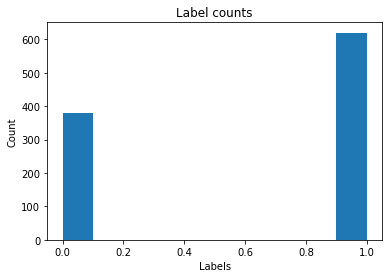

In [2]:
# simulate data 
X, y, info_dict = simulate_ll(n=1000, p=20, uncorr_frac=0.1, num_groups=5)

# plotting labels 
ax = plt.subplot()
plt.hist(y)
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
ax.set_title("Label counts")
print("xlabels: {}".format(ax.get_xlabel()))

<AxesSubplot:>

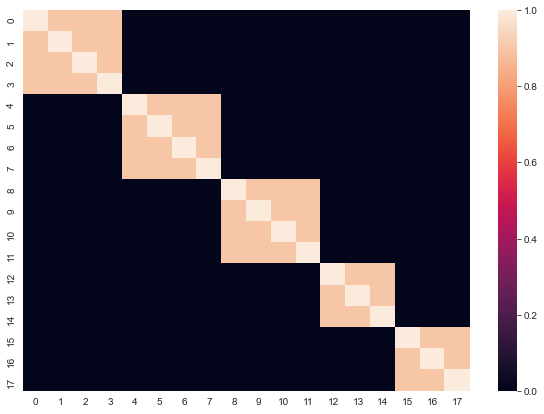

In [3]:
# generated covariance matrix and plotting it 
# -- this is the same shown as the notebook
cov_matrix = info_dict["sigma"]
sns.set({"figure.figsize" : (10, 7)})
sns.heatmap(cov_matrix)

## Creating an ElasticNet Model with generated feature labels and feature scores

In [4]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
                             average_precision_score,
                             roc_auc_score)
from scipy.stats import sem

## Plotting functions

In [5]:
def multi_line_plot(x, ys, x_err=None, y_scale=None):
	""" plots multi lines with nested arrays"""
	fig = plt.figure(figsize=(10, 7))
	colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get the default color cycle

	for indx, y in enumerate(ys):
		lable_name = "Model {}".format(indx)
  		# creating subplot 
		ax = plt.subplot()

		if y_scale == "log":
			ax.set_yscale(y_scale)
   
		# setting data plot
		ax.plot(x, y, label=lable_name, color=colors[indx])
		ax.legend(loc="upper right", prop={'size' : 8})

## Main Code

In [6]:
# Creating a for loop that controls and stores all the model perfromance
l1_ratios = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
random_states_val = np.random.randint(100, size=20).tolist()

labled_best_models = defaultdict(None)
for idx, random_state in enumerate(random_states_val):

	# Dictionary containing data per model
	scores = defaultdict(None)

	# training the model with provided randomness
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
	model_cv = LogisticRegressionCV(cv=3, penalty="elasticnet", solver="saga", l1_ratios=l1_ratios).fit(X_train, y_train)

	# Testing model with testin set
	y_pred = model_cv.predict(X_test)
	aupr_score = average_precision_score(y_test, y_pred)
	auroc_score = roc_auc_score(y_test, y_pred)

	# storing model scores
	scores["Elastic_model"] = model_cv
	scores["Random seed"] = random_state
	scores["l1_ratio"] = model_cv.l1_ratio_[0]
	scores["Cs_score"] = model_cv.Cs_
	scores["AUPR_score"] = round(aupr_score, 3)
	scores["AUROC_score"] = round(auroc_score, 3)
	scores["mean"] = np.mean(X_train.flatten())
	scores["SEM_xtrain"] = np.round(sem(X_train.flatten()), 5)
	scores["Model_score"] = model_cv.score(X_test, y_test)

	# storing into main dictioanry 
	labled_best_models["Model {}".format(idx)] = scores

In [7]:
# preprocessing data 

cs_scores = []
sem = []
aupr_scores = []
auroc_scores = []
for model_name, model_data in labled_best_models.items():
	cs_scores.append(model_data["Cs_score"])
	sem.append(model_data["SEM_xtrain"])
	auroc_scores.append(model_data["AUROC_score"])
	aupr_scores.append(model_data["AUPR_score"])
x_indx = [i+1 for i in range(len(aupr_scores))]
print(len(aupr_scores))  
print(len(x_indx))

20
20


<ErrorbarContainer object of 3 artists>

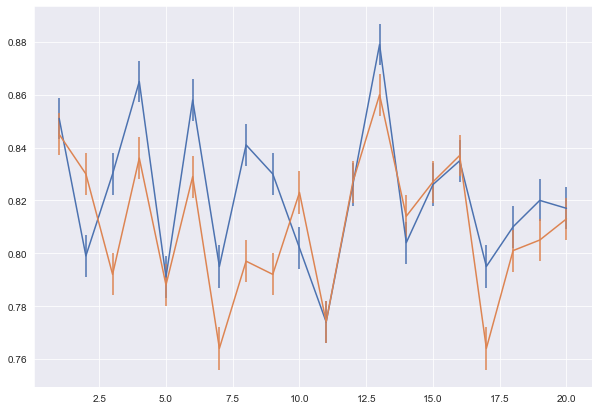

In [8]:
ax = plt.subplot()
ax.errorbar(x_indx, aupr_scores, yerr=sem)
ax.errorbar(x_indx, auroc_scores, yerr=sem)

In [ ]:
# plotting the best l1_ratios based on different selection
best_l1_ratios = []
for model_name, model_data in labled_best_models.items():
	l1_ratio = model_data["l1_ratio"]
	best_l1_ratios.append(l1_ratio)

In [ ]:
top_l1_ratio = Counter(best_l1_ratios)
l1_ratio, counts = top_l1_ratio.most_common(1)[0]
l1_ratio

0.5